In [1]:
%matplotlib inline
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
from utils import *

W0725 21:40:07.322513 139701196052288 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0725 21:40:07.592371 139701196052288 deprecation_wrapper.py:119] From /home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/ipynb/utils.py:119: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.



## Opening the black box of MCMC
The previous two chapters hid the inner-mechanics of TFP, and more generally Markov Chain Monte Carlo (MCMC), from the reader. The reason for including this chapter is three-fold. The first is that any book on Bayesian inference must discuss MCMC. I cannot fight this. Blame the statisticians. Secondly, knowing the process of MCMC gives you insight into whether your algorithm has converged(Converged to what? We will get to that). Thirdly, we'll understand why we are returned thousands of samples from the posterior as a solution, which at first thought can be odd.

## The Bayesian landscape
When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the surface, or curve, that sits on top of the space, that reflects the prior probability of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely).

In [13]:
x_ = y_ = np.linspace(0., 5., 100., dtype=np.float32)
X_, Y_ = evaluate(tf.meshgrid(x_, y_))

uni_x_ = evaluate(tfd.Uniform(low=0., high=5.0).prob(x_))
m_ = np.median(uni_x_)

uni_y_ = evaluate(tfd.Uniform(low=0., high=5.).prob(y_))
M_ = evaluate(tf.matmul(tf.expand_dims(uni_x_, 1), tf.expand_dims(uni_y_, 0)))

In [6]:
from mpl_toolkits.mplot3d import Axes3D

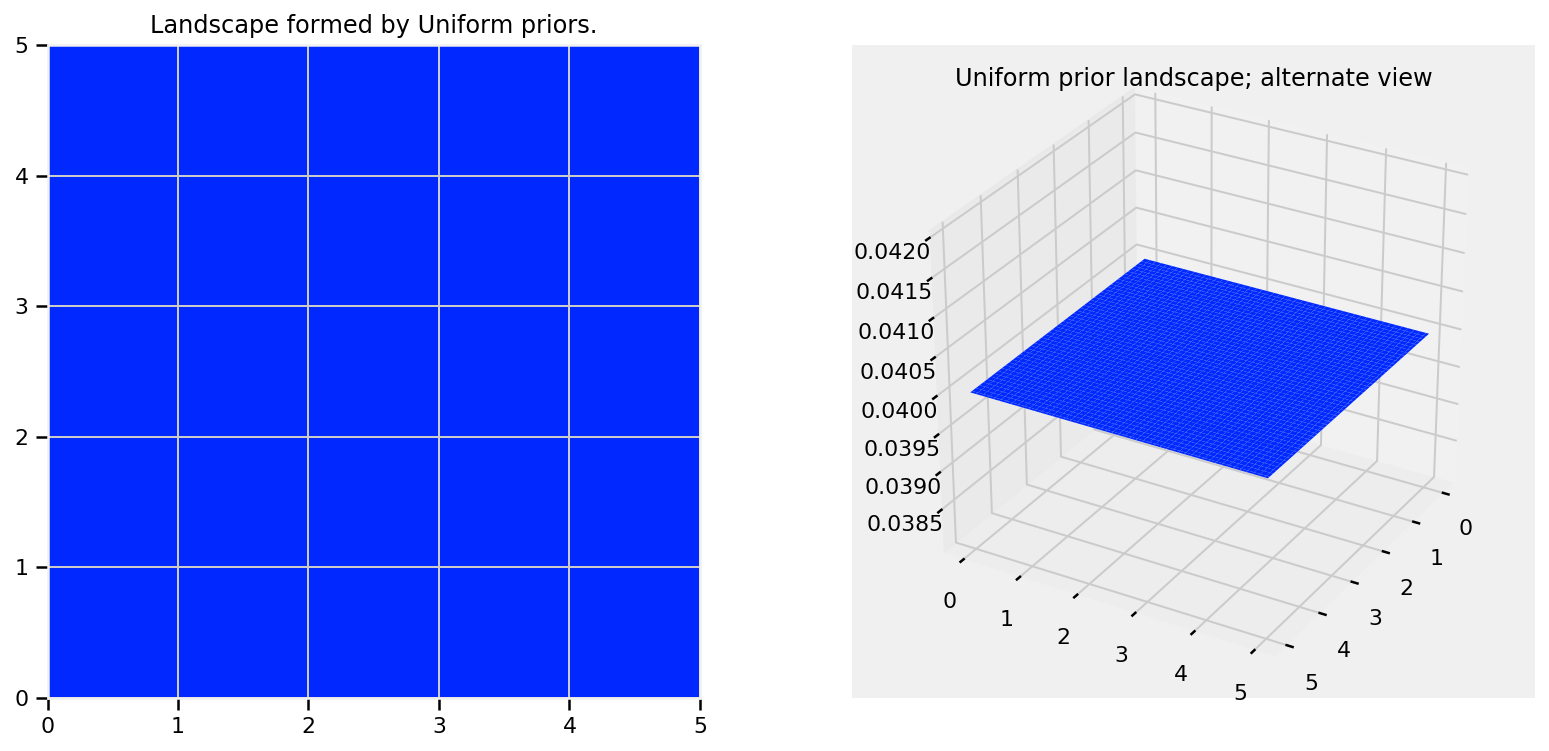

In [8]:
jet = plt.cm.jet
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
im = plt.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")
 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more the color, the more prior probability is assigned to that location. Conversely, areas with represent that our priors assign very low probability to that location.

In [14]:
exp_x_ = evaluate(tfd.Exponential(rate=(1./3.)).prob(x_))
exp_y_ = evaluate(tfd.Exponential(rate=(1./10.)).prob(y_))

M_ = evaluate(tf.matmul(tf.expand_dims(exp_x_, 1), tf.expand_dims(exp_y_, 0)))

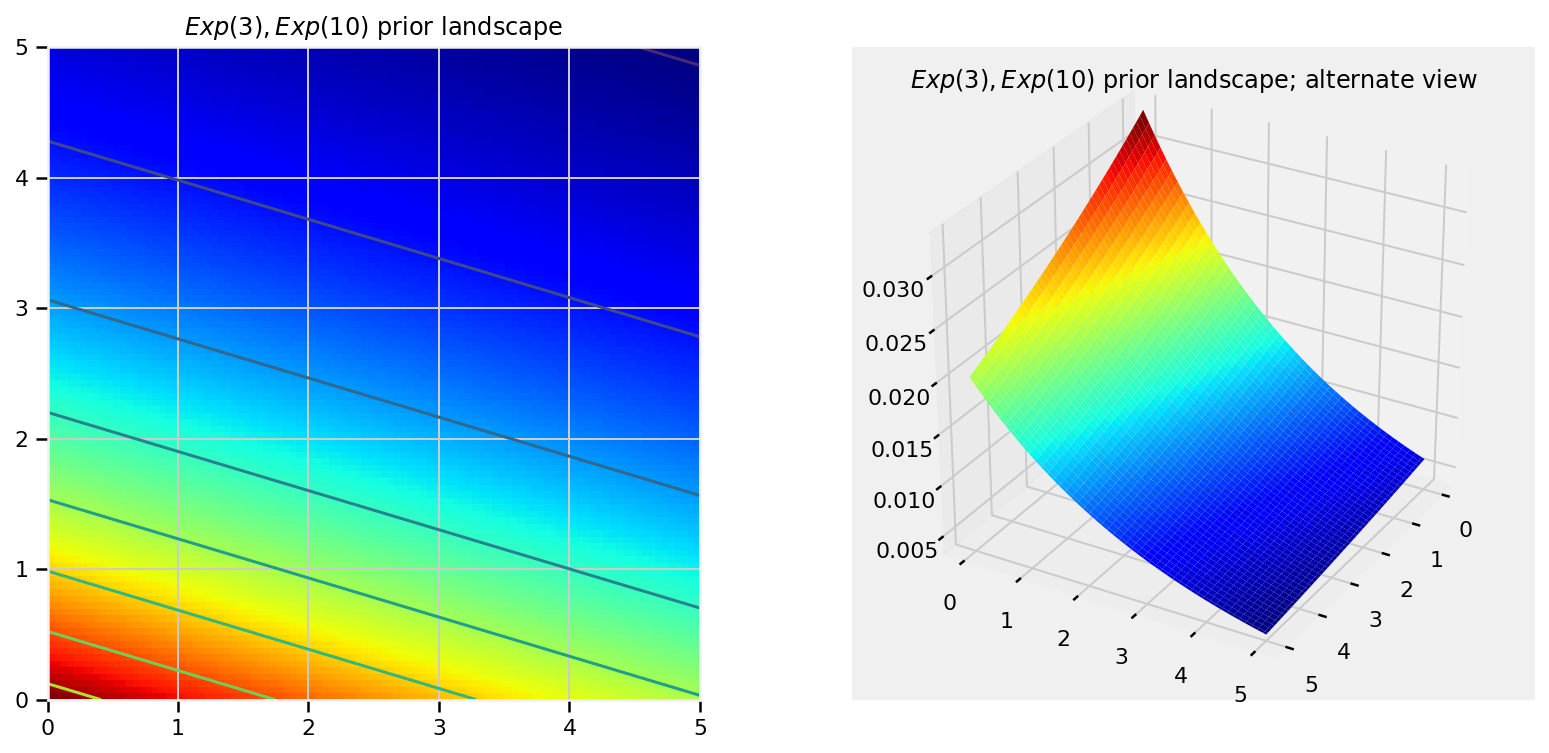

In [15]:
jet = plt.cm.jet
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
CS = plt.contour(X_, Y_, M_)
im = plt.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title(r"$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet)
ax.view_init(azim=30)
plt.title(r"$Exp(3), Exp(10)$ prior landscape; alternate view");

These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional.

If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data  $X$? The data $X$ does not change the space, but it changes the surface of the space by pulling and stretching the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the posterior distribution.

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially pushes up the original surface to make tall mountains. The tendency of the observed data to push up the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there.

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape:

In [21]:
# create the observed data
# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 15 # param {type: 'slider', min:1, max:15, step:1}

# the true parameters, but of course we don't see these values...
lambda_1_true = float(1.)
lambda_2_true = float(3.)

# We see the data generated, dependent on the above two values.
data = tf.concat([
    tfd.Poisson(rate=lambda_1_true).sample(sample_shape=(N, 1), seed=4),
    tfd.Poisson(rate=lambda_2_true).sample(sample_shape=(N, 1), seed=8)
], axis=1)
data_ = evaluate(data)
print('observed (2-dimensional, sample size = %d): \n' % N, data_)

observed (2-dimensional, sample size = 15): 
 [[3. 4.]
 [1. 3.]
 [1. 1.]
 [2. 4.]
 [2. 2.]
 [1. 2.]
 [0. 3.]
 [1. 1.]
 [1. 4.]
 [0. 2.]
 [0. 5.]
 [1. 1.]
 [0. 3.]
 [0. 8.]
 [0. 4.]]


In [22]:
# plotting details.
x_ = y_ = np.linspace(.01, 5, 100)

likelihood_x = tf.math.reduce_prod(tfd.Poisson(rate=x_).prob(data_[:,0][:,tf.newaxis]),axis=0)
likelihood_y = tf.math.reduce_prod(tfd.Poisson(rate=y_).prob(data_[:,1][:,tf.newaxis]),axis=0)

L_ = evaluate(tf.matmul(likelihood_x[:,tf.newaxis],likelihood_y[tf.newaxis,:]))

In [23]:
def plot_contour(M, x, y, lambda_1_true, lambda_2_true, title=None, **kwargs):
    plt.contour(x, y, M)
    im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5), **kwargs)
    plt.title(title)
    plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
    plt.xlim(0, 5)
    plt.ylim(0, 5)

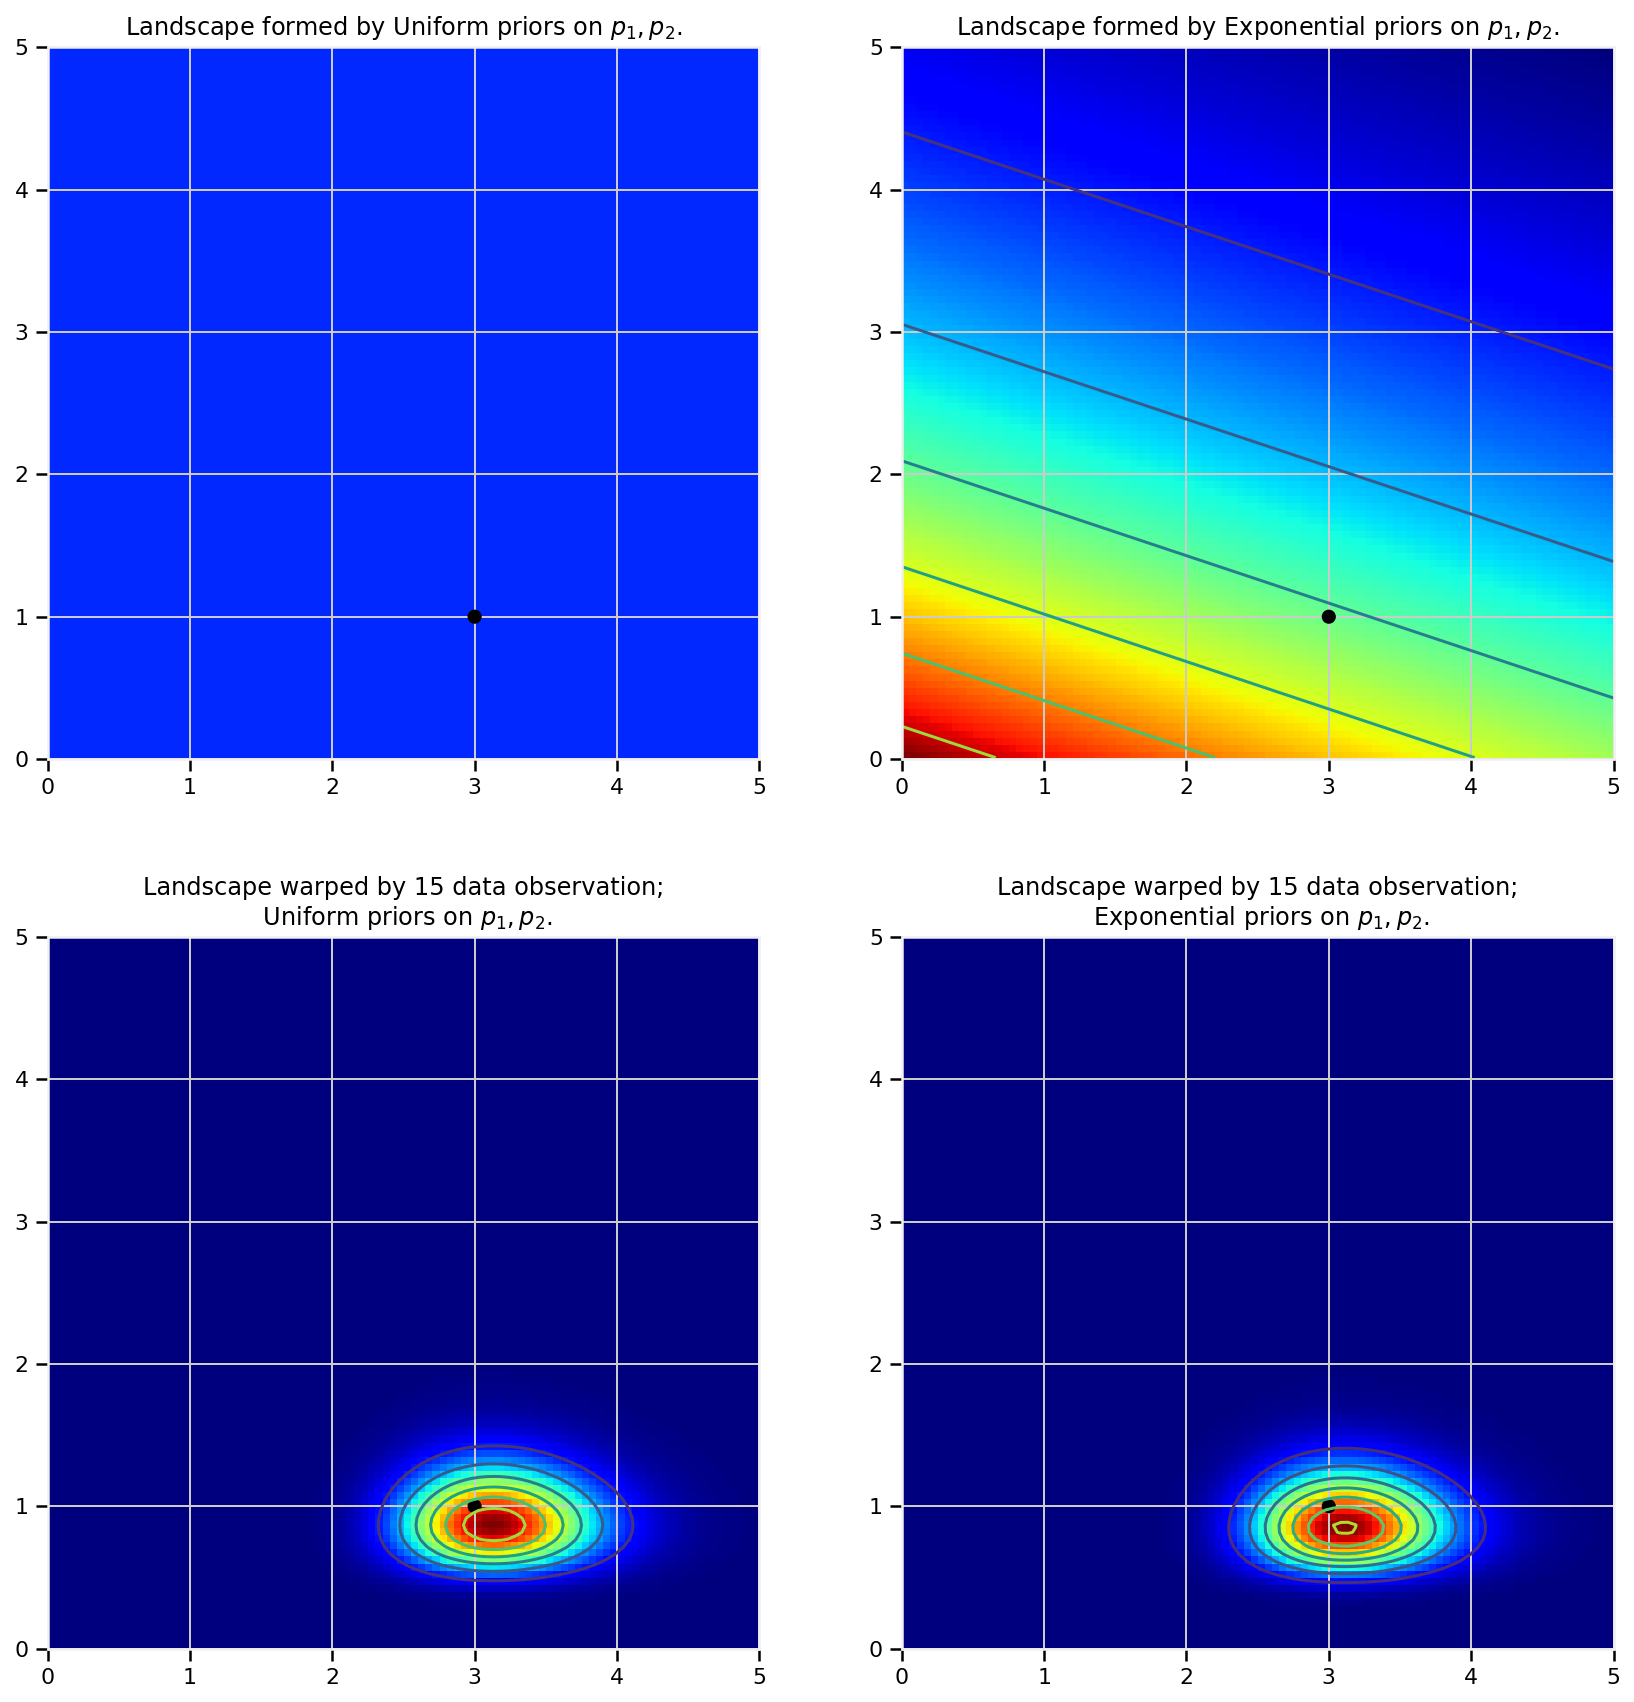

In [24]:
plt.figure(figsize(12.5, 15.0))
# matplotlib heavy lifting below, beware!

# SUBPLOT for regular Uniform
uni_x_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.cast(x_,dtype=tf.float32)))
m = np.median(uni_x_[uni_x_ > 0])
uni_x_[uni_x_ == 0] = m
uni_y_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.cast(y_,dtype=tf.float32)))
m = np.median(uni_y_[uni_y_ > 0])
uni_y_[uni_y_ == 0] = m

M_ = evaluate(tf.matmul(tf.expand_dims(uni_x_, 1), tf.expand_dims(uni_y_, 0)))
plt.subplot(221)
plot_contour(M_, x_, y_, lambda_1_true, lambda_2_true, 
             title=r"Landscape formed by Uniform priors on $p_1, p_2$.",
             vmax=1, vmin=-.15)

# SUBPLOT for Uniform + Data point
plt.subplot(223)
plot_contour(M_ * L_, x_, y_, lambda_1_true, lambda_2_true,
             title="Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)

# SUBPLOT for regular Exponential
plt.subplot(222)
exp_x_ = evaluate(tfd.Exponential(rate=.3).prob(tf.to_float(x_)))
exp_x_[np.isnan(exp_x_)] = exp_x_[1]
exp_y_ = evaluate(tfd.Exponential(rate=.10).prob(tf.to_float(y_)))
exp_y_[np.isnan(exp_y_)] = exp_y_[1]
M_ = evaluate(tf.matmul(tf.expand_dims(exp_x_, 1), tf.expand_dims(exp_y_, 0)))
plot_contour(M_, x_, y_, lambda_1_true, lambda_2_true,
             title="Landscape formed by Exponential priors on $p_1, p_2$.")


# SUBPLOT for Exponential + Data point
plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plot_contour(M_ * L_, x_, y_, lambda_1_true, lambda_2_true)
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N);

The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, top right figure, puts very little posterior weight on values in the upper right corner of the figure: this is because the prior does not put much weight there. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there.

Notice also the highest-point, corresponding the the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative.

It's a great exercise to try changing the sample size to other values (try 2, 5, 10, 100?...) and observing how our "mountain" posterior changes.

## Exploring the landscape using the MCMC
We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain. However, we cannot naively search the space: any computer scientist will tell you that traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ (see the curse of dimensionality). What hope do we have to find these hidden mountains? The idea behind MCMC is to perform an intelligent search of the space. To say "search" implies we are looking for a particular point, which is perhaps not an accurate as we are really looking for a broad mountain.

Recall that MCMC returns samples from the posterior distribution, not the distribution itself. Stretching our mountainous analogy to its limit, MCMC performs a task similar to repeatedly asking "How likely is this pebble I found to be from the mountain I am searching for?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain.

When I say MCMC intelligently searches, I really am saying MCMC will hopefully converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a broader area in the space and randomly walks in that area, picking up samples from that area.

### Why Thousands of Samples?
At first, returning thousands of samples to the user might sound like being an inefficient way to describe the posterior distributions. I would argue that this is extremely efficient. Consider the alternative possibilities:

1. Returning a mathematical formula for the "mountain ranges" would involve describing a N-dimensional surface with arbitrary peaks and valleys.
2. Returning the "peak" of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the shape of the landscape, which we have previously argued is very important in determining posterior confidence in unknowns.
Besides computational reasons, likely the strongest reason for returning samples is that we can easily use The Law of Large Numbers to solve otherwise intractable problems. I postpone this discussion for the next chapter. With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram.



### Algorithms to perform MCMC
There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows: (Mathematical details can be found in the appendix.)

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4. 
    * A) If you accept: Move to the new position. Return to Step 1.
    * B) Else: Do not move to new position. Return to Step 1.
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions that are likely not from the posterior but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). We can describe this property as memorylessness, i.e. the algorithm does not care how it arrived at its current position, only that it is there.

Other approximation solutions to the posterior
Besides MCMC, there are other procedures available for determining the posterior distributions. A Laplace approximation is an approximation of the posterior using simple functions. A more advanced method is Variational Bayes. All three methods, Laplace Approximations, Variational Bayes, and classical MCMC have their pros and cons. We will only focus on MCMC in this book.



### Example: Unsupervised Clustering using a Mixture Model

In [27]:
reset_sess()

import wget 
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv'
filename = wget.download(url)
filename

'mixture_data.csv'

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


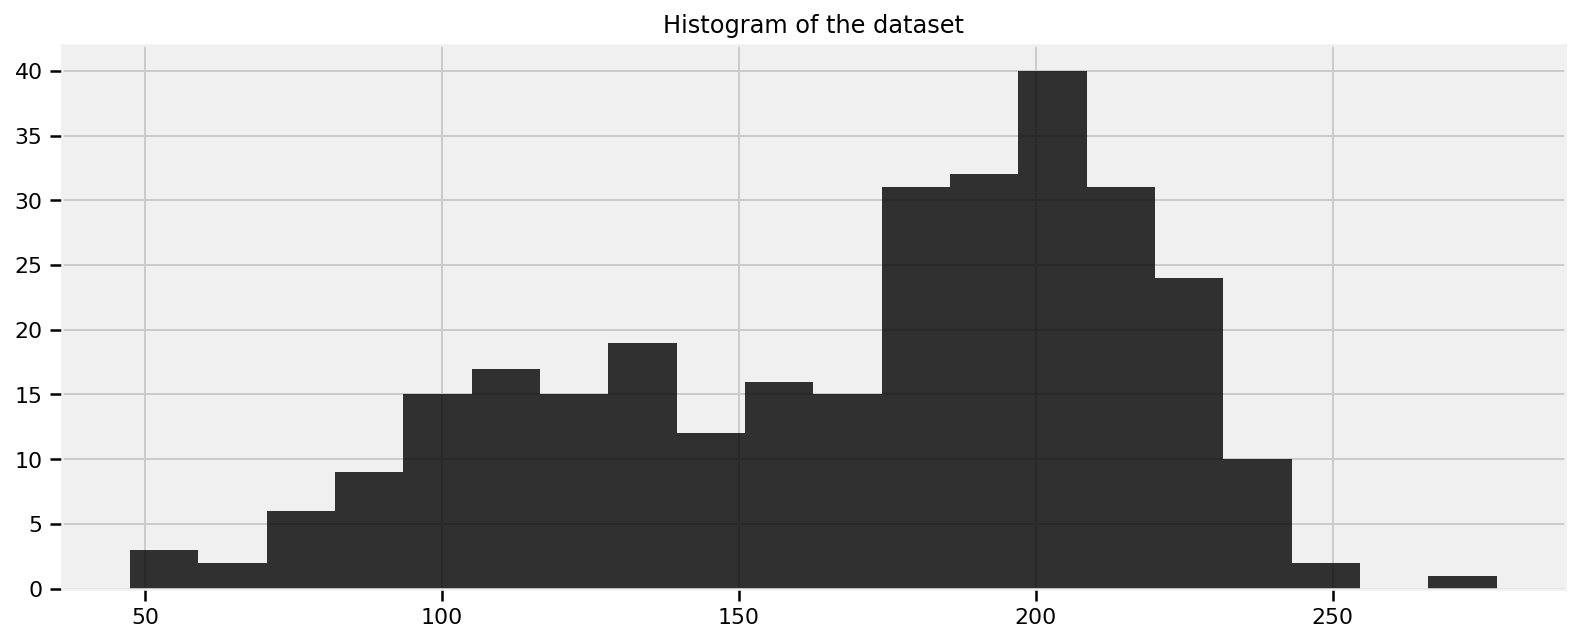

In [45]:
plt.figure(figsize=(12, 5))
data_ = np.loadtxt('mixture_data.csv', delimiter=',')
plt.hist(data_, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.ylim([0, None]);
print(data_[:10], '...')

In [46]:
p1 = tfd.Uniform(name='p', low=0, high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])

rv_assignment = tfd.Categorical(name='assignment', probs=p)
assignment = rv_assignment.sample(sample_shape=data_.shape[0])

[
    p_,
    assignment_, 
] = evaluate([
    p,
    assignment
])

print('Prior assignment, with p = %.2f: ' % p_[0])
print(assignment_[:10])

Prior assignment, with p = 0.38: 
[1 1 1 0 0 1 0 0 1 1]


In [47]:
rv_sds = tfd.Uniform(name='rv_sds', low=[0, 0], high=[100, 100])
print(str(rv_sds))

rv_centers = tfd.Normal(name='rv_centers', loc=[120., 190.], scale=[10., 10.])

sds = rv_sds.sample()
print('shape of sds sample:', sds.shape)
centers = rv_centers.sample()

rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = rv_assignments.sample(sample_shape=10)

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=rv_assignments,
    components_distribution=tfd.Normal(loc=centers, scale=sds)
)

observations = rv_observations.sample(sample_shape=10)

[
    assignments_,
    observations_,
    sds_,
    centers_,
] = evaluate([
    assignments,
    observations,
    sds,
    centers
])

print('Simulated data: ', observations_[:4], "...")
print("Random assignments: ", assignments_[:4], '...')
print("Assigned center: ", centers_[:4], "...")
print("Assigned standard deviation: ", sds_[:4], "...")

tfp.distributions.Uniform("rv_sds/", batch_shape=[2], event_shape=[], dtype=float32)
shape of sds sample: (2,)
Simulated data:  [216.30347 165.10005 191.43756 106.94358] ...
Random assignments:  [1 1 1 0] ...
Assigned center:  [113.84147 178.96204] ...
Assigned standard deviation:  [92.865135 49.876762] ...


In [48]:
def joint_log_prob(data_, sample_prob_1, sample_centers, sample_sds):
    """Joint log probability optimization function.
    
    Parameters
    ----------
    data: tensor array
        Original data
    sample_prob_1: scalar
        Probability (out of 1.0) of assignment being 0
    sample_sds: 2d vector
        Standard deviations for both normal distributions in model
    sample_centers: 2d vector
        Centers for both normal dists in model

    Returns
    -------
    Joint log probability optimization function
    """
    # Create a mixture of two scalar Gaussians
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sds = tfd.Uniform(name='rv_sds', low=[0, 0], high=[100., 100.])
    rv_centers = tfd.Normal(name='rv_centers', loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(
        mixture_distribution=rv_assignments,
        components_distribution=tfd.Normal(
            loc=sample_centers,
            scale=sample_sds)
    )
    return (rv_prob.log_prob(sample_prob_1)
           + rv_prob.log_prob(sample_prob_2)
           + tf.reduce_sum(rv_observations.log_prob(data_))
           + tf.reduce_sum(rv_centers.log_prob(sample_sds)))

In [49]:
number_of_steps = 25000
burnin = 1000
num_leapfrog_steps = 3

initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
]

# Define a closure over our joint_log_probs.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)

# Initialize the step size
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

In [44]:
reset_sess()

In [50]:
# Defining the HMC
hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

In [51]:
[
    posterior_prob,
    posterior_centers,
    posterior_sds
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [52]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_,
    posterior_centers_,
    posterior_sds_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_sds,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(
    new_step_size_initializer_))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.19704
final step size: 0.05490667000412941


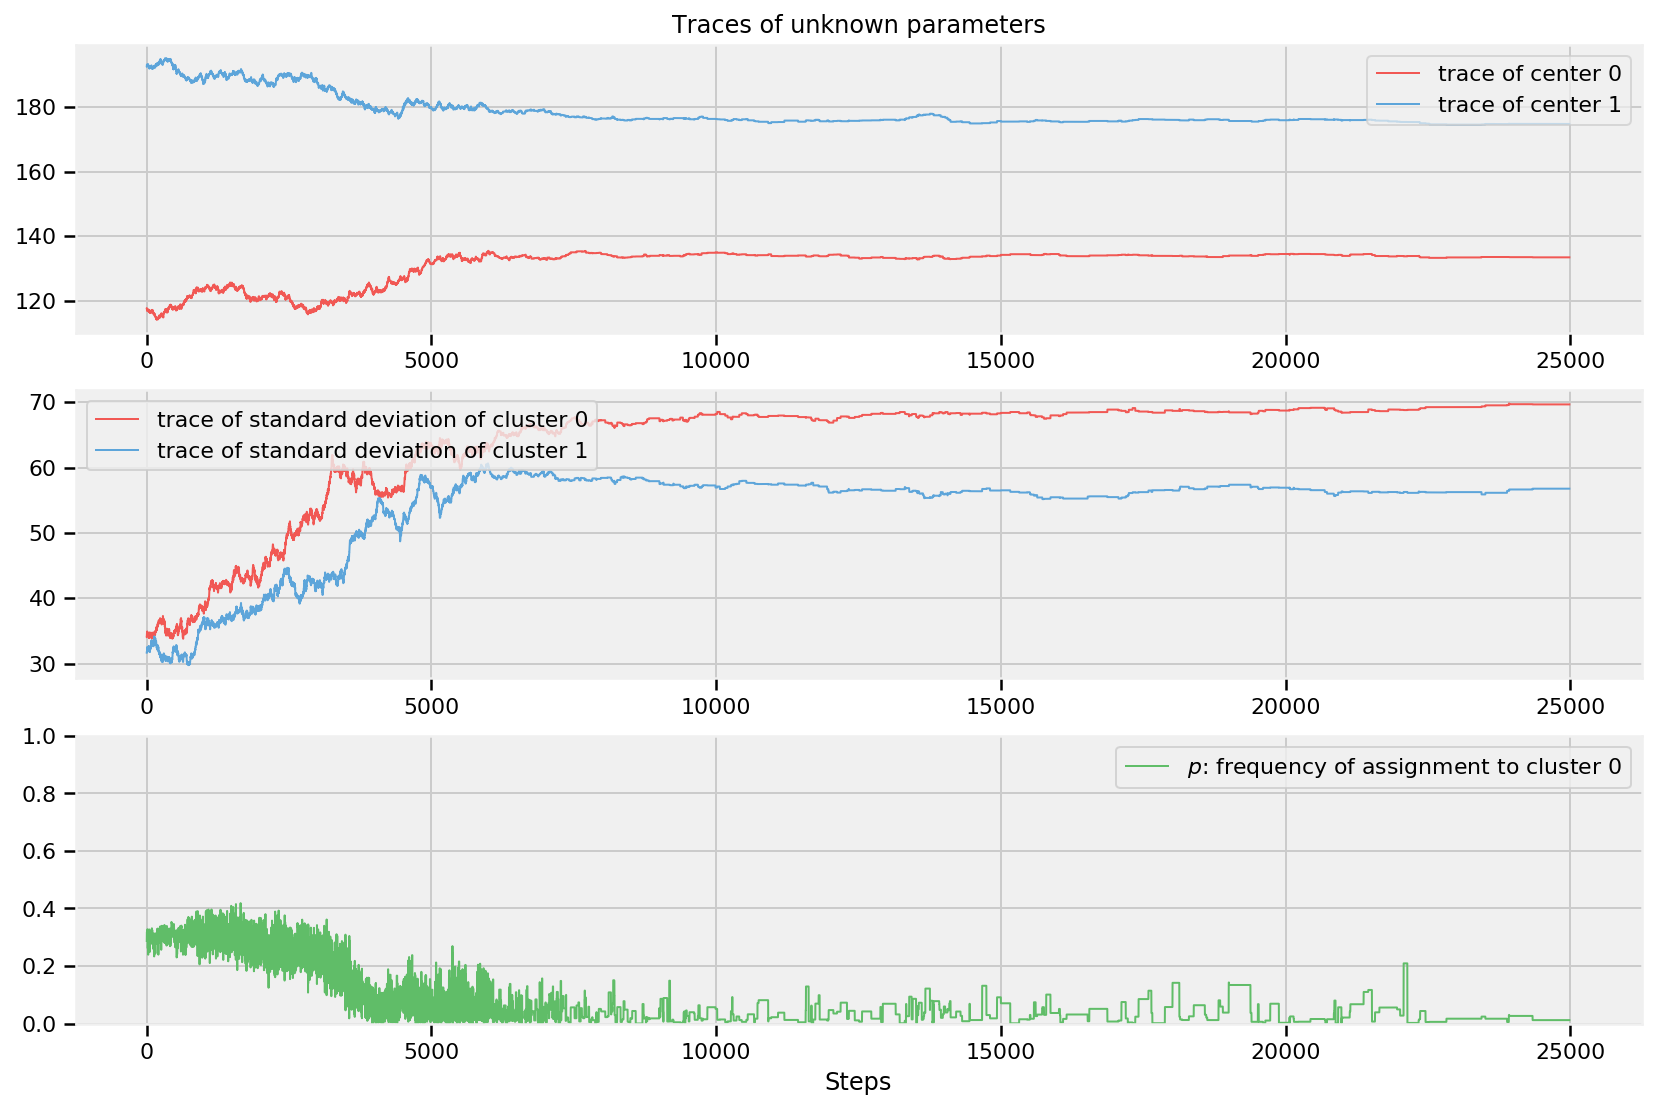

In [53]:
plt.figure(figsize(12.5, 9))
plt.subplot(311)
lw = 1
center_trace = posterior_centers_

# for pretty colors later in the book.
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] \
    else [TFColor[0], TFColor[3]]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = posterior_sds_
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_prob_
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();